In [82]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data.config import *
from report.dumps import *
from nn.model import model
from nn.funcs import *
import matplotlib.pyplot as plt
from data.dataset import * 



In [83]:
def test(ds, verbose=False, phase="Validation"):
    ds.reset()
    hits = 0
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y, train=False)
        print(o)
        hits += batch_hits(o, y)
        mean_loss += np.mean(batch_loss)
        #if verbose:
        #    print("Loss: " + str(mean_loss), " Predicted: " + str(o), " Expected: " + str(y))
    accuracy = float(hits) / float(ds.size)
    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(phase + " Accuracy: " + str(accuracy) + " Mean Loss " + str(mean_loss))
    return accuracy, mean_loss

In [84]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        hits = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            nn.backward(y,o)
            nn.update(hp.lr)

            hits += batch_hits(o, y)
            cur_trained += len(x)
            train_loss += np.mean(batch_loss)

            if cur_iter % hp.validate_every_no_of_batches == 0:

                train_accuracy = float(hits) / float(cur_trained)
                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, train_accuracy)
                logger.write( (cur_epoch, "Training", cur_iter, train_accuracy, train_loss) )
                hits = 0
                train_loss = 0

                val_accuracy, val_loss = test(hp.ds_val, True)
                val_hist.add(cur_iter, val_loss, val_accuracy)
                logger.write( (cur_epoch, "Val", cur_iter, val_accuracy, val_loss) )
            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

In [85]:
# MSE Loss and Gradient Functions
def mse_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mse_loss_grad(y_true, y_pred):
    return -2 * (y_true - y_pred) / y_true.size

def _shuffle(x, y):
    assert(len(x) == len(y)), "Making sure data and labels have the same length!"
    rand_indexes = np.random.permutation(len(x))
    return x[rand_indexes], y[rand_indexes]

((96, 4), (96, 1)) ((24, 4), (24, 1)) ((30, 4), (30, 1))
[[3.07899677]
 [5.32075603]
 [1.57268134]
 [4.41625234]
 [1.18307633]
 [5.03182458]
 [0.99789756]
 [3.68320455]
 [5.03982475]
 [1.68620076]]
[[3.97132862]
 [1.20894034]
 [5.27861425]
 [1.13774461]
 [3.40373633]
 [5.11093804]
 [4.87745226]
 [5.00428705]
 [1.93122618]
 [5.41602298]]
[[3.72069512]
 [1.43232666]
 [0.983328  ]
 [5.11660535]]
Validation Accuracy: 0.0 Mean Loss 0.026476097533165904
[[4.65499877]
 [3.30943079]
 [4.03899859]
 [4.26646943]
 [3.94741361]
 [5.64562021]
 [5.73295025]
 [1.36840747]
 [5.47849864]
 [1.20079653]]
[[1.41353197]
 [1.88539018]
 [1.18851761]
 [5.66922475]
 [5.35206354]
 [5.24811838]
 [1.26761372]
 [5.5137079 ]
 [1.5316414 ]
 [3.6326567 ]]
[[5.30977013]
 [5.38633067]
 [2.05345203]
 [1.71665515]]
Validation Accuracy: 0.0 Mean Loss 0.014467177106207199
[[4.10793194]
 [4.62010521]
 [5.51125821]
 [1.29651976]
 [1.26641227]
 [2.02914353]
 [4.29836908]
 [5.69132779]
 [1.49695046]
 [1.30176057]]
[[5.29776851

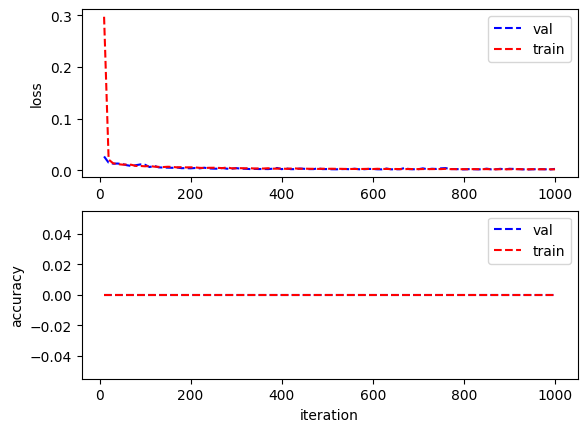

In [86]:
def prepare_iris_regression_dataset(batch_size):
    iris = load_iris()
    X = iris.data
    y = iris.data[:, 2]  # Petal length as the target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    splitter = dataset_splitter(X, y.reshape(-1, 1), batch_size)
    return splitter.ds_train, splitter.ds_val, splitter.ds_test

# Load hyperparameters for the IRIS dataset
hp = hyperparams(ConfigEnum.IRIS)
hp.output_size = 1
hp.batch_size = 10  # Example batch size
hp.ds_train, hp.ds_val, hp.ds_test = prepare_iris_regression_dataset(hp.batch_size)
hp.validate_every_no_of_batches = 10
hp.epochs = 100
hp.lr = 0.01
hp.has_dropout = False

# Initialize the model
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_grad, has_dropout=hp.has_dropout, dropout_perc=hp.dropout_perc)
nn.output_activation = lambda x: x  # Identity function
nn.output_activation_grad = lambda x: 1  # Derivative of identity is 1
nn.loss = mse_loss
nn.loss_grad = mse_loss_grad

# Historians and logger
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Loss"))

# Train the model
train(nn, hp, val_hist, train_hist, logger)

# Test the model
test(hp.ds_test, verbose=True, phase="Test")

# Plot results
nnplotter.view(val_hist, train_hist)

# Close logger
logger.close()

In [87]:
def predict(nn, X):
    outputs = []
    for x in X:
        o, _ = nn.forward(x.reshape(1, -1), y=None, train=False)
        outputs.append(o)
    return np.array(outputs).flatten()

# Function to plot the linear regression line
def plot_regression_line(nn, X_train, y_train, X_test, y_test):
    # Predict outputs for train and test sets
    y_train_pred = predict(nn, X_train)
    y_test_pred = predict(nn, X_test)
    
    # Plot training data and regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, 2], y_train, color='blue', label='Train Data')
    plt.scatter(X_test[:, 2], y_test, color='green', label='Test Data')
    plt.plot(X_train[:, 2], y_train_pred, color='red', label='Regression Line')
    plt.xlabel('Feature (Petal Length)')
    plt.ylabel('Target (Petal Length)')
    plt.title('Linear Regression on IRIS Dataset (Petal Length)')
    plt.legend()
    plt.show()

# Extract the training and test data from the dataset class instances
X_train = hp.ds_train.compl_x
y_train = hp.ds_train.compl_y
X_test = hp.ds_test.compl_x
y_test = hp.ds_test.compl_y

# Plot the regression line
plot_regression_line(nn, X_train, y_train, X_test, y_test)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'